# Problem 4 - Trajectory Optimization for a planar arm

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [1]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Compute the end effector (the ball) position and velocity using symbolic variables

This is how we get the expression in `kinematic_constraints.py`

In [23]:
# Computes the end effector velocity as xdot, ydot J_q (pos) * qdot

from sympy import *
import numpy as np

l, q0, q1, qdot0, qdot1 = symbols('l q0 q1 qdot0 qdot1', real=True)
pos = l * Matrix([-sin(q0), -cos(q0)]) + \
      l * Matrix([-sin(q0 + q1), -cos(q0 + q1)])
vel = Matrix(pos).jacobian([q0, q1]) @ np.reshape(np.array([qdot0, qdot1]), (2,1))

print('pos (x_ball, z_ball):\n', pos)
print('')
print('vel (x_ball dot, z_ball dot):\n', vel)

pos (x_ball, z_ball):
 Matrix([[-l*sin(q0) - l*sin(q0 + q1)], [-l*cos(q0) - l*cos(q0 + q1)]])

vel (x_ball dot, z_ball dot):
 Matrix([[-l*qdot1*cos(q0 + q1) + qdot0*(-l*cos(q0) - l*cos(q0 + q1))], [l*qdot1*sin(q0 + q1) + qdot0*(l*sin(q0) + l*sin(q0 + q1))]])


## Set up Ball Trajectory

The ball is in the air for 0.6992906373179558s


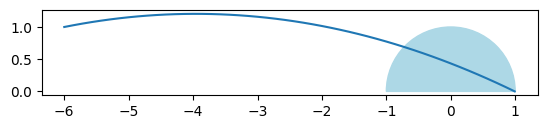

In [228]:
from matplotlib.patches import Wedge
g = 9.81

def CalcCatchPos(q0, v0, t_catch):
    y_final = q0[1] + v0[1] * t_catch
    x_final = q0[0] + v0[0] * t_catch
    z_final = q0[2] + v0[2] * t_catch - 0.5 * g * t_catch**2
    return np.array([x_final, y_final, z_final])

def tFall(q0, v0):
    # Solve 0 = q0[2] + v0[2] * t - 0.5 * g * t**2
    a = -0.5 * g
    b = v0[2]
    c = q0[2]
    return (-b - np.sqrt(b*b - 4*a*c)) / (2*a)

q0_ball = np.array([-6, 0, 1])
v0_ball = np.array([10, 0, 2])

max_t = tFall(q0_ball, v0_ball)
print(f'The ball is in the air for {max_t}s')
plot_t = np.linspace(0, max_t, 50)
plot_q = np.array([CalcCatchPos(q0_ball, v0_ball, t) for t in plot_t])

fig, ax = plt.subplots()
plt.gca().set_aspect('equal')
ax.plot(plot_q[:,0], plot_q[:,2])
# ax.add_patch(plt.Circle((0,0), 1, color='lightblue'))
ax.add_patch(Wedge((0,0), 1, 0, 180, color='lightblue'))
plt.show()

## Run trajectory optimization to find the optimal trajectory

In [229]:
import importlib
import catching_trajectory
importlib.reload(catching_trajectory)
from catching_trajectory import find_throwing_trajectory

N = 5
initial_state = [0, 0, 0, -0.5, 0, 0, 0] + [0] * 7
final_configuration = np.array([np.pi, 0])
tf = 1
distance = 15.0

x_traj, u_traj, t_catch, prog, _, _ = find_throwing_trajectory(N, q0_ball, v0_ball, initial_state, final_configuration, distance)


n_q =  7
n_v =  7
n_x =  14
n_u =  7
[87. 87. 87. 87. 12. 12. 12.]
[2.175 2.175 2.175 2.175 2.61  2.61  2.61 ]
Solver is  SNOPT
optimal cost:  74471.19639257673
x_sol:  [[ 0.         -0.         -0.         -0.5         0.          0.
   0.          0.         -0.          0.          0.         -0.
  -0.          0.        ]
 [-0.03294416 -0.21731715  0.32290593 -0.84759207  0.12592026  0.2098927
   0.09531235  2.175      -2.175       2.175      -2.175       2.61
   2.61        2.61      ]
 [ 0.40455293 -0.40674358  0.48389941 -0.89704615  0.47503735  0.44657695
   0.47160832  2.175      -2.175       2.175      -0.96866821  2.61
   1.64811251  2.31228481]
 [ 0.49216335 -0.69601225  0.74572984 -1.0547552   0.71399159  0.46812251
   0.63215916  2.175      -2.175       2.175      -0.67864241  2.61
  -2.08901566  2.61      ]
 [ 0.82763432 -0.90609114  0.9971936  -1.14145233  1.05470784  0.13976369
   1.03947429  2.175      -2.175       2.175      -2.175       2.61
  -1.85232188  2.61     

## Validate the Solution

In [230]:
print('Ball Position', CalcCatchPos(q0_ball, v0_ball, t_catch).ravel())
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
Parser(plant).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

context = plant.CreateDefaultContext()
context.SetContinuousState(x_traj.value(t_catch))
ee_frame = plant.GetBodyByName("panda_link8").body_frame()
ee_pos = plant.CalcPointsPositions(context, ee_frame, np.zeros(3), plant.world_frame()).ravel()
np.set_printoptions(suppress=True)
print('EE Position', ee_pos)

Ball Position [-0.44535814  0.          0.59753741]
EE Position [-0.4453583  -0.0000004   0.70407069]


/var/folders/5t/0kxy2vx919lgwxxs0m5q271h0000gn/T/ipykernel_1625/2628686991.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  context.SetContinuousState(x_traj.value(t_catch))


## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import time

from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource,
    AddMultibodyPlantSceneGraph
)


# Create a MultibodyPlant for the arm
# file_name = "planar_arm.urdf"
builder = DiagramBuilder()
ball, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
# scene_graph = builder.AddSystem(SceneGraph())
planar_arm = builder.AddSystem(MultibodyPlant(0.0))
# planar_arm, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
planar_arm.RegisterAsSourceForSceneGraph(scene_graph)
# Parser(plant=planar_arm).AddModels(file_name)
Parser(plant=planar_arm).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
planar_arm.WeldFrames(planar_arm.world_frame(), planar_arm.GetFrameByName("panda_link0"))
planar_arm.Finalize()

# ball = builder.AddSystem(MultibodyPlant(0.0))
Parser(plant=ball).AddModels("./ball.urdf")
ball.Finalize()
# ball.RegisterAsSourceForSceneGraph(scene_graph)
# builder.Connect(ball.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(ball.get_source_id()))
# builder.Connect(scene_graph.get_query_output_port(), ball.get_geometry_query_input_port())

n_q = planar_arm.num_positions()
n_v = planar_arm.num_velocities()
n_u = planar_arm.num_actuators()

x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(planar_arm))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), planar_arm.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(planar_arm.get_source_id()))
builder.Connect(scene_graph.get_query_output_port(), planar_arm.get_geometry_query_input_port())

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the motion for `n_playback` times
n_playback = 3
for i in range(n_playback):
  # Set up a simulator to run this diagram.
    context = diagram.CreateDefaultContext()
    ball.SetPositions(ball.GetMyContextFromRoot(context), [0, 0, 0, 1, *q0_ball])
    ball.SetVelocities(ball.GetMyContextFromRoot(context), [0, 0, 0, *v0_ball])
    simulator = Simulator(diagram, context)
    simulator.Initialize()
    time.sleep(1)
    simulator.set_target_realtime_rate(0.2)
    simulator.AdvanceTo(t_catch);
    time.sleep(1)

/var/folders/5t/0kxy2vx919lgwxxs0m5q271h0000gn/T/ipykernel_1625/775774928.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulator.AdvanceTo(t_catch);
